In [1]:
from time import time
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv('../input/medical-speech-transcription-and-intent/medical speech transcription and intent/Medical Speech, Transcription, and Intent/overview-of-recordings.csv')
df = df[['phrase', 'prompt']]
print('shape:', df.shape)
print('null : ',df.isnull().sum().sum())
df.head()

shape: (6661, 2)
null :  0


,phrase,prompt
0,When I remember her I feel down,Emotional pain
1,When I carry heavy things I feel like breaking...,Hair falling out
2,there is too much pain when i move my arm,Heart hurts
3,My son had his lip pierced and it is swollen a...,Infected wound
4,My muscles in my lower back are aching,Infected wound


In [38]:
df.iloc[3, 0]

'there is too much pain when i move my arm'

In [3]:
df.to_csv('2_col_data.csv', index=False)


In [4]:
# Detect TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [5]:
from kaggle_datasets import KaggleDatasets

AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path()
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

BackendError: Unexpected response from the service. Response: {'errors': ["Notebook has more than one data source. Please specify the directory name of the dataset in the call to get_gcs_path. For example, if a dataset is available at /kaggle/input/example-data, then pass the directory name like this: get_gcs_path('example-data')"], 'error': {'code': 3, 'details': []}, 'wasSuccessful': False}.

In [6]:
embedding_dim = 100    # glove6b100
max_length = 30        # max lenght of a tweet
trunc_type='post'      # it will cut the tweet if it is longer than 20
padding_type='post'    # it will add zeros at the end the tweets if is smaller than 20
oov_tok = "<OOV>"      # for unseen words 
training_size=6661
test_portion=0.20

In [71]:
for label, index in enumerate(df.prompt.unique()) :
    print(label, index)

0 Emotional pain
1 Hair falling out
2 Heart hurts
3 Infected wound
4 Foot ache
5 Shoulder pain
6 Injury from sports
7 Skin issue
8 Stomach ache
9 Knee pain
10 Joint pain
11 Hard to breath
12 Head ache
13 Body feels weak
14 Feeling dizzy
15 Back pain
16 Open wound
17 Internal pain
18 Blurry vision
19 Acne
20 Muscle pain
21 Neck pain
22 Cough
23 Ear ache
24 Feeling cold


In [8]:
import csv

num_sentences = 0
corpus = []

with open("/kaggle/working/2_col_data.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        list_item=[]
        list_item.append(row[0])
        this_label=row[1]
        if this_label=='Emotional pain':
            list_item.append(0)
        elif this_label=='Hair falling out':
            list_item.append(1)
        elif this_label=='Heart hurts':
            list_item.append(2)
        elif this_label=='Infected wound':
            list_item.append(3)
        elif this_label=='Foot ache':
            list_item.append(4)
        elif this_label=='Shoulder pain':
            list_item.append(5)
        elif this_label=='Injury from sports':
            list_item.append(6)
        elif this_label=='Skin issue':
            list_item.append(7)
        elif this_label=='Stomach ache':
            list_item.append(8)
        elif this_label=='Knee pain':
            list_item.append(9)
        elif this_label=='Joint pain':
            list_item.append(10)
        elif this_label=='Hard to breath':
            list_item.append(11)
        elif this_label=='Head ache':
            list_item.append(12)
        elif this_label=='Body feels weak':
            list_item.append(13)
        elif this_label=='Feeling dizzy':
            list_item.append(14)
        elif this_label=='Back pain':
            list_item.append(15)
        elif this_label=='Open wound':
            list_item.append(16)
        elif this_label=='Internal pain':
            list_item.append(17)
        elif this_label=='Blurry vision':
            list_item.append(18)
        elif this_label=='Acne':
            list_item.append(19)
        elif this_label=='Muscle pain':
            list_item.append(20)
        elif this_label=='Neck pain':
            list_item.append(21)
        elif this_label=='Cough':
            list_item.append(22)
        elif this_label=='Ear ache':
            list_item.append(23)
        else:
            list_item.append(24)
        num_sentences = num_sentences + 1
        corpus.append(list_item)

In [11]:
print(num_sentences)
print(corpus[4])

6662
['My son had his lip pierced and it is swollen and the skin inside on his lip is grey and looks infected.', 3]


In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random 

sentences=[]
labels=[]

random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

In [21]:
print(vocab_size)
print(word_index['ok']) 

1162
979


In [22]:
embeddings_index = {};

with open('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;
        
print(embeddings_matrix.shape)


(1163, 100)


In [23]:
embeddings_index['love']

array([ 2.5975e-01,  5.5833e-01,  5.7986e-01, -2.1361e-01,  1.3084e-01,
        9.4385e-01, -4.2817e-01, -3.7420e-01, -9.4499e-02, -4.3344e-01,
       -2.0937e-01,  3.4702e-01,  8.2516e-02,  7.9735e-01,  1.6606e-01,
       -2.6878e-01,  5.8830e-01,  6.7397e-01, -4.9965e-01,  1.4764e+00,
        5.5261e-01,  2.5295e-02, -1.6068e-01, -1.3878e-01,  4.8686e-01,
        1.1420e+00,  5.6195e-02, -7.3306e-01,  8.6932e-01, -3.5892e-01,
       -5.1877e-01,  9.0402e-01,  4.9249e-01, -1.4915e-01,  4.8493e-02,
        2.6096e-01,  1.1352e-01,  4.1275e-01,  5.3803e-01, -4.4950e-01,
        8.5733e-02,  9.1184e-02,  5.0177e-03, -3.4645e-01, -1.1058e-01,
       -2.2235e-01, -6.5290e-01, -5.1838e-02,  5.3791e-01, -8.1040e-01,
       -1.8253e-01,  2.4194e-01,  5.4855e-01,  8.7731e-01,  2.2165e-01,
       -2.7124e+00,  4.9405e-01,  4.4703e-01,  5.5882e-01,  2.6076e-01,
        2.3760e-01,  1.0668e+00, -5.6971e-01, -6.4960e-01,  3.3511e-01,
        3.4609e-01,  1.1033e+00,  8.5261e-02,  2.4847e-02, -4.54

In [24]:
with strategy.scope():    
    
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
        #tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Bidirectional(LSTM(units=64, return_sequences=True)),
        tf.keras.layers.Bidirectional(LSTM(units=128)),
        tf.keras.layers.Dense(64, activation='relu'),  #, kernel_regularizer=regularizers.l2(0.01)
        tf.keras.layers.Dense(25, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['sparse_categorical_accuracy'])
    model.summary()
    
    num_epochs = 30
    
    training_padded = np.array(training_sequences)
    training_labels = np.array(training_labels)
    testing_padded = np.array(test_sequences)
    testing_labels = np.array(test_labels)
    
    history = model.fit(training_padded, 
                        training_labels, 
                        epochs=num_epochs, 
                        validation_data=(testing_padded, testing_labels),
                        batch_size = 32,
                        verbose=1)
    
    print("Training Complete")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           116300    
_________________________________________________________________
dropout (Dropout)            (None, 30, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 128)           84480     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1625      
Total params: 482,021
Trainable params: 365,721
Non-trainable params: 116,300
____________________________________________

<Figure size 432x288 with 0 Axes>

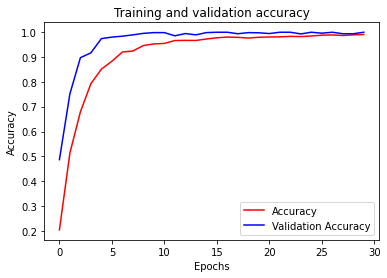

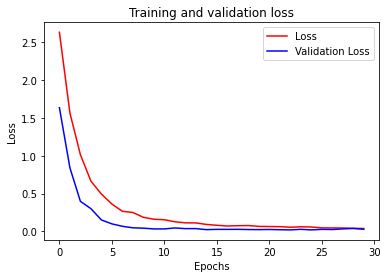

<Figure size 432x288 with 0 Axes>

In [25]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['sparse_categorical_accuracy']
val_acc=history.history['val_sparse_categorical_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()

In [88]:
new_sentence = ['I have a headache']
sequence = tokenizer.texts_to_sequences(new_sentence)
padded = pad_sequences(sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)
model.predict(padded)

array([[1.91034960e-05, 1.04675999e-11, 3.40765496e-07, 2.48407854e-08,
        7.60109197e-06, 1.84957443e-07, 2.26518239e-07, 3.74837578e-06,
        2.24380055e-05, 1.14413076e-07, 1.75127163e-04, 2.11399644e-08,
        9.99067247e-01, 2.78265938e-10, 5.22498800e-09, 1.49184143e-06,
        1.54655311e-08, 1.88435966e-04, 4.33041606e-07, 2.53143884e-09,
        3.22991724e-07, 2.34145823e-08, 5.12595405e-04, 2.01389014e-07,
        3.08239635e-07]], dtype=float32)

In [89]:
score = np.amax(model.predict(padded))
classs = np.where(model.predict(padded) == np.amax(model.predict(padded)))[1][0]

print(' class :', classs,'\n','score :', score)

 class : 12 
 score : 0.99906725


In [90]:
model.save('texte_classification.h5')
